Importing the libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os

import cv2
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the dataset to local environment

In [ ]:
!apt-get install p7zip-full
!7za x '/content/drive/MyDrive/Datasetzip'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 folder, 1 file, 241675852 bytes (231 MiB)

Extracting archive: /content/drive/MyDrive/Datasetzip/Datastcn.zip
--
Path = /content/drive/MyDrive/Datasetzip/Datastcn.zip
Type = zip
Physical Size = 241675852

  0%      6% 170 - Datastcn/datasetcn/COVID/Covid (115).png

Creating a dataframe

In [ ]:
data_train = []
type_of_disease =['COVID', 'non-COVID']
data_directory = '/content/Datastcn/datasetcn'
train_directory = os.path.join(data_directory)

for id, td in enumerate(type_of_disease):
    for file in os.listdir(os.path.join(train_directory, td)):
        data_train.append(['{}/{}'.format(td, file), id, td])
        
train = pd.DataFrame(data_train, columns=['Image', 'Class ID','Type of Disease'])
train.head()

,Image,Class ID,Type of Disease
0,COVID/Covid (362).png,0,COVID
1,COVID/Covid (1115).png,0,COVID
2,COVID/Covid (782).png,0,COVID
3,COVID/Covid (696).png,0,COVID
4,COVID/Covid (1116).png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))
train.head()

,Image,Class ID,Type of Disease
0,COVID/Covid (447).png,0,COVID
1,COVID/Covid (764).png,0,COVID
2,non-COVID/Non-Covid (797).png,1,non-COVID
3,non-COVID/Non-Covid (1221).png,1,non-COVID
4,COVID/Covid (482).png,0,COVID


In [ ]:
def show_images(disease_type, r, c):
    fig,ax = plt.subplots(r,c, figsize=(10,10))
    disease_image = train['Image'][train['Type of Disease'] == disease_type].values
    n = 0
    print(disease_type+' images')
    for i in range(r):
        for j in range(c):
            image = os.path.join(data_directory, disease_image[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image))
            n += 1


Plotting the covid images

In [ ]:
SIZE_OF_IMAGE = 150
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)

Reshaping all the images to 150 * 150 * 3

In [ ]:
x_train = np.zeros((train.shape[0], SIZE_OF_IMAGE, SIZE_OF_IMAGE, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train[i] = resize_image(image,(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
        
X_Train = x_train / 255

print('Train shape: {}'.format(X_Train.shape))

2481it [00:08, 277.98it/s]


Train shape: (2481, 150, 150, 3)


In [ ]:
y_train = train['Class ID'].values
y_train = to_categorical(y_train, num_classes=2)

Train test split(0.8,0.2)

In [ ]:
BATCH_SIZE = 64

X_train, X_test, Y_train, Y_test = train_test_split(X_Train,y_train, test_size=0.2, random_state=SEED)

In [ ]:
EPOCHS = 30
SIZE=150
N_ch=3

Creating the inceptionv3 model with imagenet weights initially and trained the model

In [ ]:
def build_inceptionv3():
    inceptionv3 = InceptionV3(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = inceptionv3(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(2,activation = 'softmax', name='root')(x)
 
    model = Model(input,output)
    
    optimizer = RMSprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_inceptionv3()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/inecptionV31905_best.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, Y_test))

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 150, 150, 3)       84        
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
31/31 - 61s - loss: 1.0758 - accuracy: 0.5907 - val_loss: 1.0595 - val_accuracy: 0.5070

Epoch 00001: val_loss improved from inf to 1.05953, saving model to /content/drive/MyDrive/Colab Notebooks/inecptionV31905_best.h5
Epoch 2/30
31/31 - 12s - loss: 0.8619 - accuracy: 0.6663 - val_loss: 1.1410 - val_accuracy: 0.5513

Epoch 00002: val_loss did not improve from 1.05953
Epoch 3/30
31/31 - 12s - loss: 0.7737 - accuracy: 0.7152 - val_loss: 1.3382 - val_accuracy: 0.5231

Epoch 00003: val_loss did not improve from 1.05953
Epoch 4/30
31/31 - 12s - loss: 0.7538 - accuracy: 0.7334 - val_loss: 1.9807 - val_accuracy: 0.4849

Epoch 00004: val_loss did not improve from 1.05953
Epoch 5/30
31/31 - 12s - loss: 0.6921 - accuracy: 0.7500 - val_loss: 1.4191 - val_accuracy: 0.5352

Epoch 00005: val_loss did not improve from 1.05953
Epoch 6/30
31/31 - 12s - loss: 0.6430 - accuracy: 0.7752 - val_loss: 0.8854 - val_accuracy: 0.6519

Epoch 00006: val_loss improved from 1.05953 to 0.88544, saving mo

In [ ]:
final_loss, final_acc = model.evaluate(X_test, Y_test)
print("*************************")
print('Loss: {}, Accuracy:{}'.format(final_loss, final_acc))

16/16 [==============================] - 1s 43ms/step - loss: 0.2182 - accuracy: 0.9276
*************************
Loss: 0.21823519468307495, Accuracy:0.9275653958320618


Predicting the test images

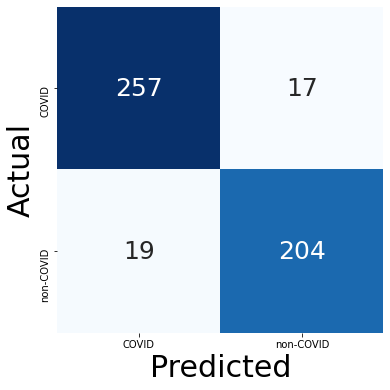

In [ ]:
Y_predict = model.predict(X_test)
Y_predict = np.argmax(Y_predict, axis= 1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_predict)
plt.figure(figsize=(6,6))

ax= sns.heatmap(cm, cmap=plt.cm.Blues, annot=True,fmt='d',annot_kws={"size": 25},cbar=False, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.savefig('Confusion matrix_inceptionV3.svg', format='svg', dpi=1200)

Accuracy and Loss plot

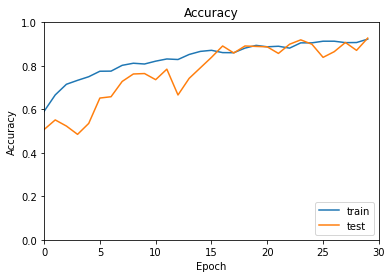

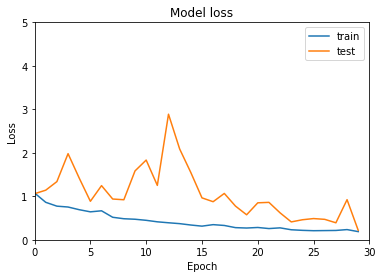

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlim(0,30)
plt.ylim(0,1)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='lower right')
plt.savefig('Accuracy plot_inceptionV3.svg', format='svg', dpi=1200)
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlim(0,30)
plt.ylim(0,5)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper right')
plt.savefig('Model loss plot_inceptionV3.svg', format='svg', dpi=1200)
plt.show()

In [ ]:
def confusion_metrics (conf_matrix):

    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    #accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    #mis-classification
    conf_misclassification = 1- conf_accuracy
    
    #sensitivity
    conf_sensitivity = (TP / float(TP + FN))

    #specificity
    conf_specificity = (TN / float(TN + FP))
    
    #precision
    conf_precision = (TN / float(TN + FP))

    # f1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)

    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f1 Score: {round(conf_f1,2)}')

In [ ]:
metrics = confusion_metrics(cm)
print(metrics)

True Positives: 204
True Negatives: 257
False Positives: 17
False Negatives: 19
--------------------------------------------------
Accuracy: 0.93
Mis-Classification: 0.07
Sensitivity: 0.91
Specificity: 0.94
Precision: 0.94
f1 Score: 0.93
None
